In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import random

from xgboost import plot_importance
from xgboost import XGBRegressor
import statsmodels.api as sm

from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('../data/processed_data/merged_characteristics.csv')
keys = ['HIOS ID', 'IssuerId', 'County', 'State', 'FIPS County Code', 'Policy County FIPS Code','County Name']
missing_cols = ['DP05_0028PE', 'Number of Consumers with CSR AV of 87%', 
                'Average Monthly Advanced CSR Payment for Consumers with 87%', 
                'DP05_0018PE', 'Number of Consumers with CSR (AV of 73%/87%/94%)', 'Total Number of Consumers',
                'Number of Consumers with CSR AV of 73%', 'Number of Consumers with CSR AV of 94%', 'FIPS County Code',
                'Average Monthly Advanced CSR Payment for Consumers with 73%', 
                'Average Monthly Advanced CSR Payment for Consumers with 94%', 
                'DP05_0032PE', 'DP05_0004PE', 'County Name']



#setup y
y_cols = ['Ever Enrolled Count']


    
x_cols = []
for col in df.columns:
    if col not in y_cols and col not in keys and col not in missing_cols: 
        x_cols.append(col)  

        
y = df[y_cols]
X = df[x_cols]

X = X/X.std()

In [3]:
training_test = []
num_trials = 10
for i in range(num_trials):
    test_size = 0.33
    np.random.seed()
    X_train, X_test, y_train, y_test = train_test_split(sm.add_constant(X), y, test_size=test_size)
    training_test.append( (X_train, X_test, y_train, y_test) )

/home/erichschulman/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [4]:
def get_predictions(model,X_test):
    y_pred = model.predict(X_test)
    y_pred[y_pred < 0] = 0
    return np.array(y_pred).reshape(X_test.shape[0],1)


def plot_prediction(split,y_pred,y_test):
    #setup the data
    
    plt.hist(y_pred[y_pred < split],label='predictions',alpha=.5,density=True)
    plt.hist(y_test[y_pred < split],label='true',alpha=.5,density=True)
    plt.legend()
    plt.show()

    plt.hist(y_pred[y_pred > split],label='predictions',alpha=.5,density=True)
    plt.hist(y_test[y_pred > split],label='true',alpha=.5,density=True)
    plt.legend()
    plt.show()
    
    
def plot_importance(X_test,model):
    #use similar code for producing rankings of features according to LASSO
    cols = np.array(X_test.columns)
    importance_raw = model.get_booster().get_score(importance_type='weight')
    importance = []

    for key in importance_raw.keys():
        importance.append([key,importance_raw[key]])

    importance  = pd.DataFrame( importance, columns=['features','score'])
    importance = importance.sort_values('score',ascending=False)

    plt.barh(importance.head(20)['features'].iloc[::-1], importance.head(20)['score'].iloc[::-1])
    plt.show()

    
def report_error(y_test,y_pred):
    y_test = y_test.copy()
    y_test['error'] = np.abs(y_test - y_pred)**2
    y_test['pred'] = y_pred
    result = y_test.merge(df, how='inner',left_index=True, right_index=True,suffixes=('','_x'))
    result  =  result.rename(columns={'Total Number of Consumers':'csr_tot',
                        'Number of Consumers with CSR AV of 94%':'csr_tot_94',
                                     'EHBPercentTotalPremium':'prices'})
    result['shares'] = result['Ever Enrolled Count']/result['DP03_0095E']
    result = result.sort_values('error',ascending=False).head(50)
    #plt.title('20 worst predictions')
    #plt.hist(result['Ever Enrolled Count'],label='true',alpha=.5,density=True)
    #plt.hist(result['pred'],label='pred',alpha=.5,density=True)
    #plt.legend()
    #plt.show()
    
    result_groupby = result.groupby('State')[['pred','Ever Enrolled Count','prices','csr_tot']].mean()
    #MetalLevel_Silver
    result_groupby = result.groupby('State')[['pred','Ever Enrolled Count']].mean()
    result_groupby[['pred_var','enroll_var']] = result.groupby('State')[['pred','Ever Enrolled Count']].std()
    result_groupby = result_groupby.sort_values('pred',ascending=False)
    return result_groupby

mse normalized trial  0 : 0.9696632727171085
mse normalized trial  1 : 0.7424703602234801
mse normalized trial  2 : 0.8366997617771957
mse normalized trial  3 : 1.026732337026484
mse normalized trial  4 : 1.540039693334511
mse normalized trial  5 : 1.0609215115905553
mse normalized trial  6 : 1.6146165543798585
mse normalized trial  7 : 0.9763606943568458
mse normalized trial  8 : 0.7117948610783067
mse normalized trial  9 : 1.4536753701699459


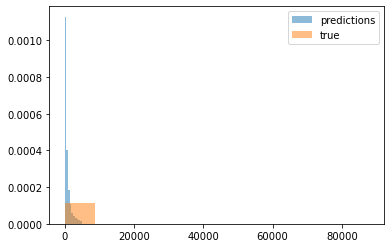

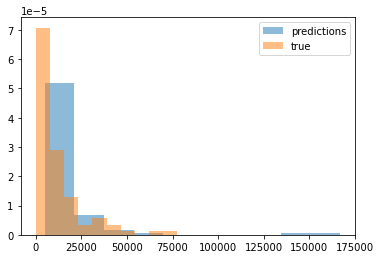

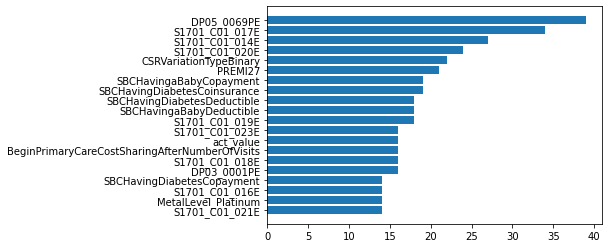

mse 34922401.1667317 r2 -0.09329744166542916
mse med 34800672.85900609 r2 med -0.001546515691664918
mse normalized trial  0 : 0.7810087835811028
mse normalized trial  1 : 0.9927796810717465
mse normalized trial  2 : 0.8569848569793379
mse normalized trial  3 : 1.5799184106003863
mse normalized trial  4 : 1.9357748379907778
mse normalized trial  5 : 0.9244456900393606
mse normalized trial  6 : 1.2847325545802957
mse normalized trial  7 : 0.9926146600926002
mse normalized trial  8 : 0.7539918518404941
mse normalized trial  9 : 1.210319919040846


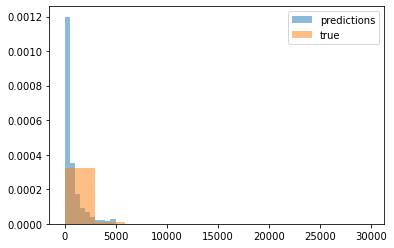

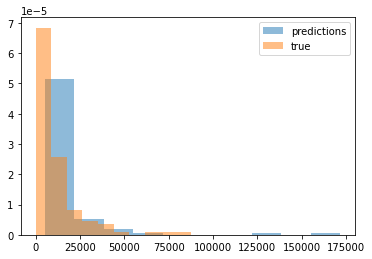

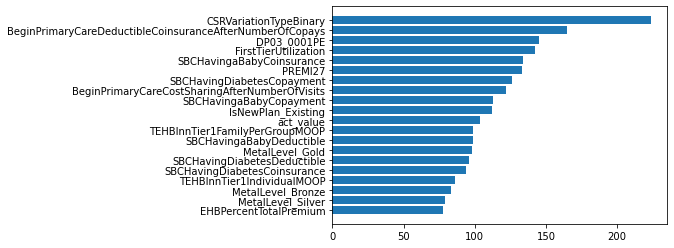

mse 35547497.4903245 r2 -0.1312571245816948
mse med 32153314.53107372 r2 med 0.007302829417826617


In [5]:
params = [(2,.5,.9,.9),(5,.5, 0.5, .9)]


for param in params:
    mses = []
    r2s = []
    for i in range(num_trials):
        X_train, X_test, y_train, y_test = training_test[i]
        # not super deep, but uses most of the data at one
        model = XGBRegressor(n_estimators=X_train.shape[1], max_depth=param[0],
                             eta=param[1], subsample=param[2], colsample_bytree=param[3])
        model.fit(X_train, y_train)

        y_pred = get_predictions(model,X_test)
        mse = float( ((y_test - y_pred)**2).mean() )
        r2 = float(  1- mse/y_test.var() ) 
        print('mse normalized trial ', i,':', float(mse/y_test.var()))
        mses.append(mse)
        r2s.append(r2)

        #plot the difference between true and predicted
        if i == num_trials -1:
            split = 5000
            plot_prediction(split,y_pred,y_test)
            plot_importance(X_test,model)

    print( 'mse', np.array(mses).mean() ,'r2', np.array(r2s).mean()  )
    print( 'mse med', np.median(mses) ,'r2 med', np.median(r2s)  )

0.7025160928944857
0.5918241632191586
0.7752658487400149
1.1414048143765632
0.6644516987158763
0.6163415721249372
0.6471197066523453
0.7172451692743316
0.7422305072550641
0.5440877396994529


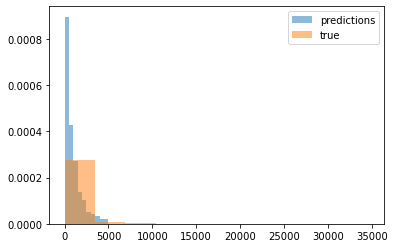

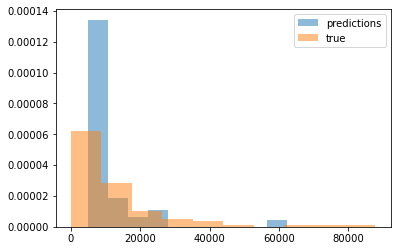

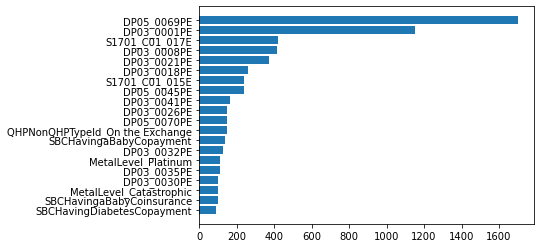

mse trial 9 :                pred  Ever Enrolled Count      pred_var    enroll_var
State                                                               
FL     24255.259052              28460.5  23032.062448  22191.442722
AZ     23536.107461               3951.0           NaN           NaN
UT     17264.236710               5796.0           NaN           NaN
TX     16761.672415              23399.5   8623.205529  22919.700215
VA     10757.168338               2588.0           NaN           NaN
OR      7692.219312              12047.5    179.407956  16754.895180
MI      6921.182601               4935.8   2999.655472   6099.555779
GA      6580.902742              17949.5    360.471253   1789.687263
MO      6274.702764              22955.0           NaN           NaN
TN      5996.386935              24894.0           NaN           NaN
PA      5984.224462              24887.0   1938.188271  15927.763057
NC      5543.183031              30867.0   3580.775573  24525.291599
WI      5534.781854 

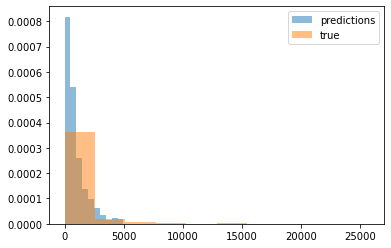

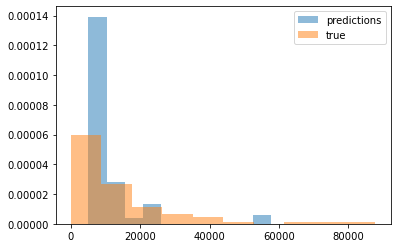

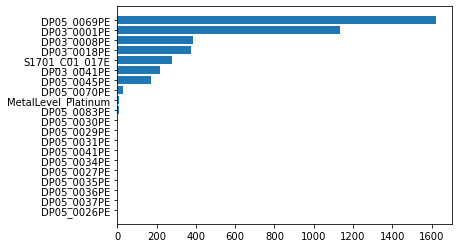

mse trial 9 :                pred  Ever Enrolled Count      pred_var    enroll_var
State                                                               
AZ     23951.495208          3951.000000           NaN           NaN
FL     21005.453549         28431.916667  22414.523301  22215.340508
TX     14319.739006         23761.076923   7816.766420  23813.984444
NJ      9666.565763           928.000000           NaN           NaN
OR      8136.279289         12047.500000      0.000000  16754.895180
UT      7283.782012          7148.000000   8366.676100   1912.016736
MI      6926.795901          4935.800000   2898.024135   6099.555779
GA      6828.748835         17949.500000      0.000000   1789.687263
MO      5982.093655         22955.000000           NaN           NaN
PA      5759.403825         24887.000000   3294.237853  15927.763057
TN      5539.836942         24894.000000           NaN           NaN
WI      5418.340661         28963.000000           NaN           NaN
NC      4679.117068 

In [6]:
# Vary alpha values
a = [100,250]

for i in a: 
    mses = []
    r2s = []
    for j in range(num_trials):
        X_train, X_test, y_train, y_test = training_test[j]
        
        lasso = sm.OLS(y_train, X_train).fit_regularized(method='elastic_net', alpha=i, L1_wt=1.0)
        y_pred = get_predictions(lasso,X_test)

        mse = float(((y_test - y_pred)**2).mean())
        r2 = float( 1 - mse/y_test.var() )
        print(float(mse/y_test.var()))
        mses.append(mse)
        r2s.append(r2)
        

        if j == num_trials -1:
            #plot the difference between true and predicted
            split = 5000
            plot_prediction(split,y_pred,y_test)

            #also plot important feature
            param_df = pd.DataFrame(np.abs(lasso.params),columns=['score']).sort_values(by=['score'], ascending=False).head(20)
            param_df['features'] = param_df.index
            plt.barh(param_df['features'].iloc[::-1], param_df['score'].iloc[::-1])
            plt.show()
            print('mse trial', j, ':',report_error(y_test,y_pred))

    print('alpha_value:', i)
    print( 'mse', np.array(mses).mean() ,'r2', np.array(r2s).mean()  )
    print( 'mse med', np.median(mses) ,'r2 med', np.median(r2s)  )
    print('==========================================')
    print('==========================================')

In [7]:
#some training sets total number of consumers?
#some times DP03_CSR?